In [16]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
import pytorch_lightning as pl
import torchmetrics
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SEED = 2024
pl.seed_everything(SEED)

Seed set to 2024


2024

## Utils

In [12]:
LEARING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE}')

Using cuda


In [23]:
def correlation_matrix(df, title):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 10))
    sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(title)
    plt.show()

In [4]:
def load_data(batch_size=BATCH_SIZE, num_workers=4):
    # Transformaciones para los datos
    transform = transforms.ToTensor()

    # Carga de datos de entrenamiento
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    
    # División entre entrenamiento y validación
    train_size = int(0.8 * len(mnist_train))
    val_size = len(mnist_train) - train_size
    mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

    # DataLoader para entrenamiento y validación
    train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True, persistent_workers=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, num_workers=num_workers, shuffle=False, persistent_workers=True)

    # Carga de datos de test
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers, persistent_workers=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data()

100%|██████████| 9912422/9912422 [00:00<00:00, 14041507.86it/s]


Extracting c:\code\ExAI\MNIST\raw\train-images-idx3-ubyte.gz to c:\code\ExAI\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28800688.02it/s]


Extracting c:\code\ExAI\MNIST\raw\train-labels-idx1-ubyte.gz to c:\code\ExAI\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3240436.27it/s]


Extracting c:\code\ExAI\MNIST\raw\t10k-images-idx3-ubyte.gz to c:\code\ExAI\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting c:\code\ExAI\MNIST\raw\t10k-labels-idx1-ubyte.gz to c:\code\ExAI\MNIST\raw



In [5]:

class MNISTModel(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super(MNISTModel, self).__init__()
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)
        self.lr = lr
        self.num_classes = num_classes
        
        # metrics
        self.train_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.val_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.precision = torchmetrics.Precision(num_classes=self.num_classes, average='macro', task='multiclass')
        self.recall = torchmetrics.Recall(num_classes=self.num_classes, average='macro', task='multiclass')
        self.f1 = torchmetrics.F1Score(num_classes=self.num_classes, average='macro', task='multiclass')

    def forward(self, x, record_activations=False):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        x_layer1 = F.relu(x)

        x = self.layer_2(x_layer1)
        x_layer2 = F.relu(x)

        x = self.layer_3(x_layer2)
        x_layer3 = F.log_softmax(x, dim=1)

        if record_activations:
            return x_layer3, [x_layer1, x_layer2, x_layer3]

        return x_layer3
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc(logits, y), prog_bar=True)
        self.log('precision', self.precision(logits, y), prog_bar=True)
        self.log('recall', self.recall(logits, y), prog_bar=True)
        self.log('f1', self.f1(logits, y), prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
model = MNISTModel(lr=LEARING_RATE)

## Train

In [6]:
trainer = pl.Trainer(max_epochs=EPOCHS)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: c:\code\ExAI\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | layer_1   | Linear              | 100 K 
1 | layer_2   | Linear              | 33.0 K
2 | layer_3   | Linear              | 2.6 K 
3 | train_acc | MulticlassAccuracy  | 0     
4 | val_acc   | MulticlassAccuracy  | 0     
5 | test_acc  | MulticlassAccuracy  | 0     
6 | precision

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
trainer.test(model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.9688427448272705     │
│         precision         │    0.9722179770469666     │
│          recall           │    0.9713566303253174     │
│         test_acc          │    0.9731000065803528     │
│         test_loss         │    0.08862943947315216    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08862943947315216,
  'test_acc': 0.9731000065803528,
  'precision': 0.9722179770469666,
  'recall': 0.9713566303253174,
  'f1': 0.9688427448272705}]

## Activations

In [8]:
def load_data_for_activations():
    # load only one image of the test set
    transform = transforms.ToTensor()
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=1, shuffle=False)
    return test_loader

test_loader_act = load_data_for_activations()

In [9]:
model_for_act = MNISTModel.load_from_checkpoint('lightning_logs/version_0/checkpoints/epoch=4-step=3750.ckpt')
model_for_act.eval()

MNISTModel(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
)

In [19]:
# Número de neuronas en cada capa
layer1_neurons = 128 
layer2_neurons = 256 
layer3_neurons = 10 

# Creación de las columnas para cada neurona
columns = ['Number']
columns += [f'Layer1_Neuron{i+1}' for i in range(layer1_neurons)]
columns += [f'Layer2_Neuron{i+1}' for i in range(layer2_neurons)]
columns += [f'Layer3_Neuron{i+1}' for i in range(layer3_neurons)]

# Estimación del tamaño del DataFrame (ajusta según tu conjunto de datos)
num_rows = len(test_loader_act) 

# Pre-creación del DataFrame
df = pd.DataFrame(index=range(num_rows), columns=columns)

# Llenar el DataFrame
for idx, batch in enumerate(tqdm(test_loader_act, desc='Running activations')):
    x, y = batch
    _, r = model_for_act(x, record_activations=True)

    # Construir fila para el DataFrame
    row = {'Number': y.item()}
    row.update({f'Layer1_Neuron{i+1}': r[0].cpu().detach().numpy()[0, i] for i in range(layer1_neurons)})
    row.update({f'Layer2_Neuron{i+1}': r[1].cpu().detach().numpy()[0, i] for i in range(layer2_neurons)})
    row.update({f'Layer3_Neuron{i+1}': r[2].cpu().detach().numpy()[0, i] for i in range(layer3_neurons)})

    df.loc[idx] = row

Running activations: 100%|██████████| 10000/10000 [00:23<00:00, 417.17it/s]


In [20]:
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.740439,0.0,0.0,0.0,0.0,0.0,0.196717,0.0,0.0,...,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.01362,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,0.0,0.0,2.195834,2.045902,0.488143,1.100444,1.067014,0.169285,1.632867,...,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,0.0,1.838184,0.470426,0.2989,0.0,0.16031,1.212221,0.0,0.665693,...,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,0.0,0.0,0.0,0.0,1.68934,0.451246,0.0,2.347926,2.136712,...,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.45652
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.782253,2.228824,...,-11.6886,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


In [21]:
# save activations csv
df.to_csv('activations.csv', index=False)

## Study activation

In [4]:
# read activations csv
folder = os.path.join(os.getcwd(), 'activations', 'activations.csv')
df = pd.read_csv(folder)
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.740439,0.000000,0.000000,0.000000,0.000000,0.000000,0.196717,0.000000,0.000000,...,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.013620,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,0.000000,0.000000,2.195834,2.045902,0.488143,1.100444,1.067014,0.169285,1.632867,...,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,0.000000,1.838184,0.470426,0.298900,0.000000,0.160310,1.212221,0.000000,0.665693,...,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,0.000000,0.000000,0.000000,0.000000,1.689340,0.451246,0.000000,2.347926,2.136712,...,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.456520
4,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.782253,2.228824,...,-11.688600,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


In [20]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

# create new dataframe
df_layer1 = df[get_layer_columns('Layer1')]
df_layer1.head()

# create new dataframe
df_layer2 = df[get_layer_columns('Layer2')]
df_layer2.head()

# create new dataframe
df_layer3 = df[get_layer_columns('Layer3')]
df_layer3.head()

,Number,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.013620,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.456520
4,4.0,-11.688600,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


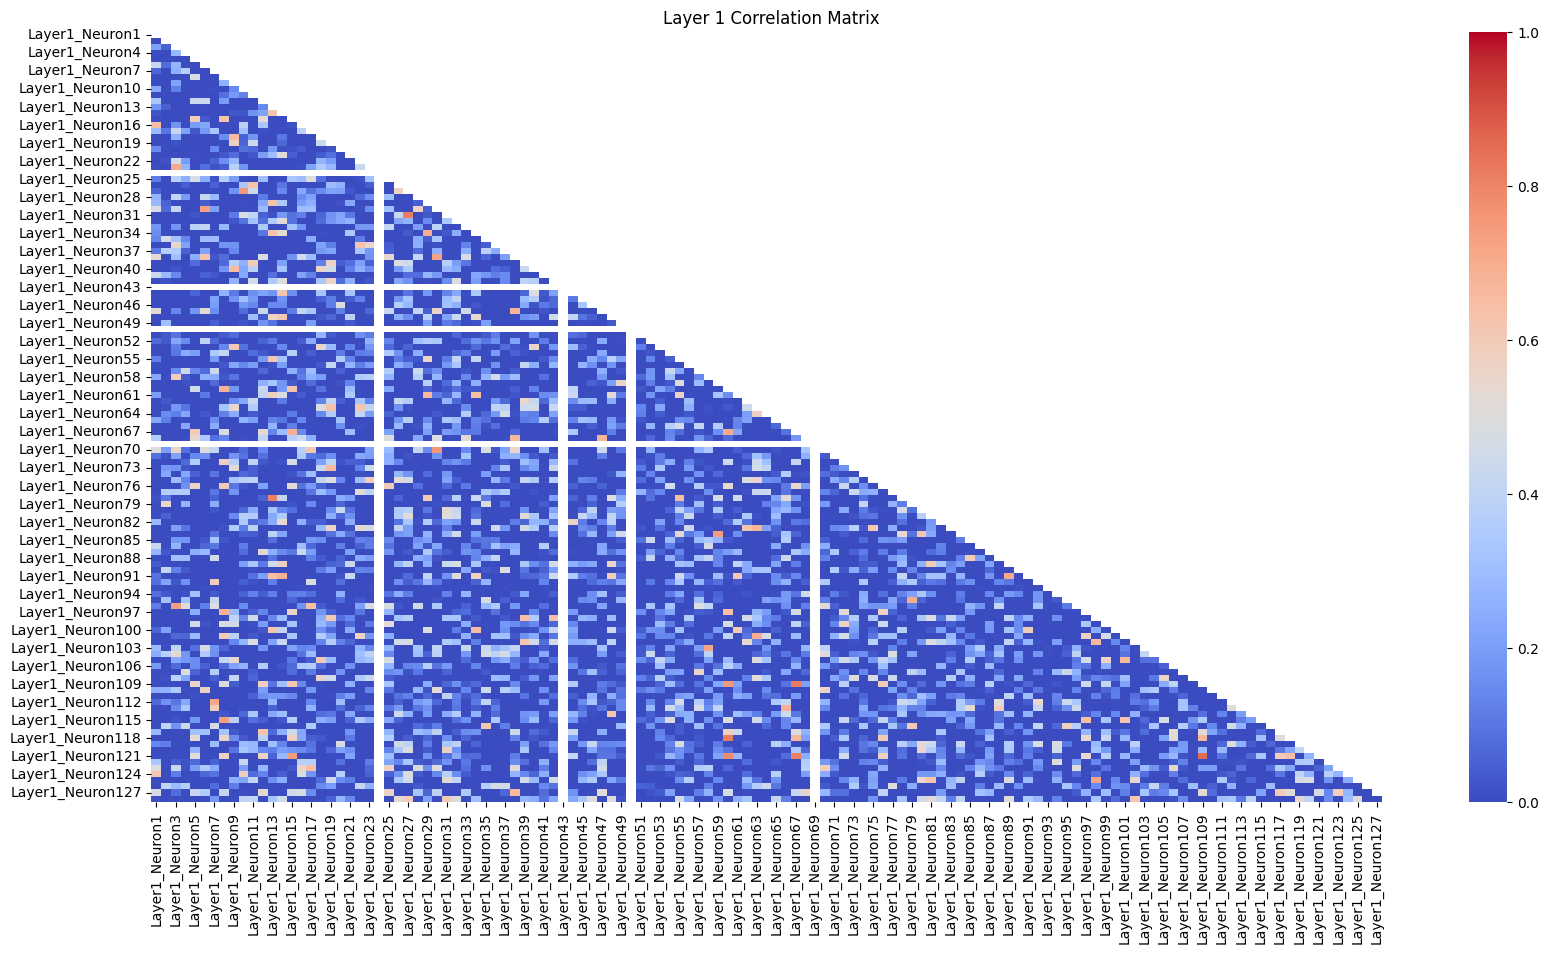

In [24]:
# plot correlation matrix
df_layer1_not_number = df_layer1.drop(columns=['Number'])
correlation_matrix(df_layer1_not_number, 'Layer 1 Correlation Matrix')


In [51]:
def IoU(activation, num_classes=10):
    results = []
    for num1 in range(10):
        for num2 in range(num1 + 1, 10):
            # Seleccionar las filas correspondientes para cada número
            df_layer1_num1_binary = df_layer1_binary[df_layer1['Number'] == num1]
            df_layer1_num2_binary = df_layer1_binary[df_layer1['Number'] == num2]

            # Calcular la intersección y la unión
            intersection = df_layer1_num1_binary & df_layer1_num2_binary
            union = df_layer1_num1_binary | df_layer1_num2_binary

            # Calcular el IoU, con manejo de división por cero
            iou = intersection.sum().sum() / union.sum().sum() if union.sum().sum() != 0 else 0

            results.append({'Number1': num1, 'Number2': num2, 'IoU': iou})
    return pd.DataFrame(results)

In [58]:
threshold = 0.1
# Convertir todo el DataFrame a binario de una vez
df_layer1_binary = df_layer1.gt(threshold).astype(bool)
df_iou_layer1 = IoU(df_layer1_binary)

df_layer2_binary = df_layer2.gt(threshold).astype(bool)
df_iou_layer2 = IoU(df_layer2_binary)

In [59]:
# get row that IoU > 0
df_iou_layer1[df_iou_layer1['IoU'] > 0]

,Number1,Number2,IoU


In [60]:
df_iou_layer2[df_iou_layer2['IoU'] > 0]

,Number1,Number2,IoU


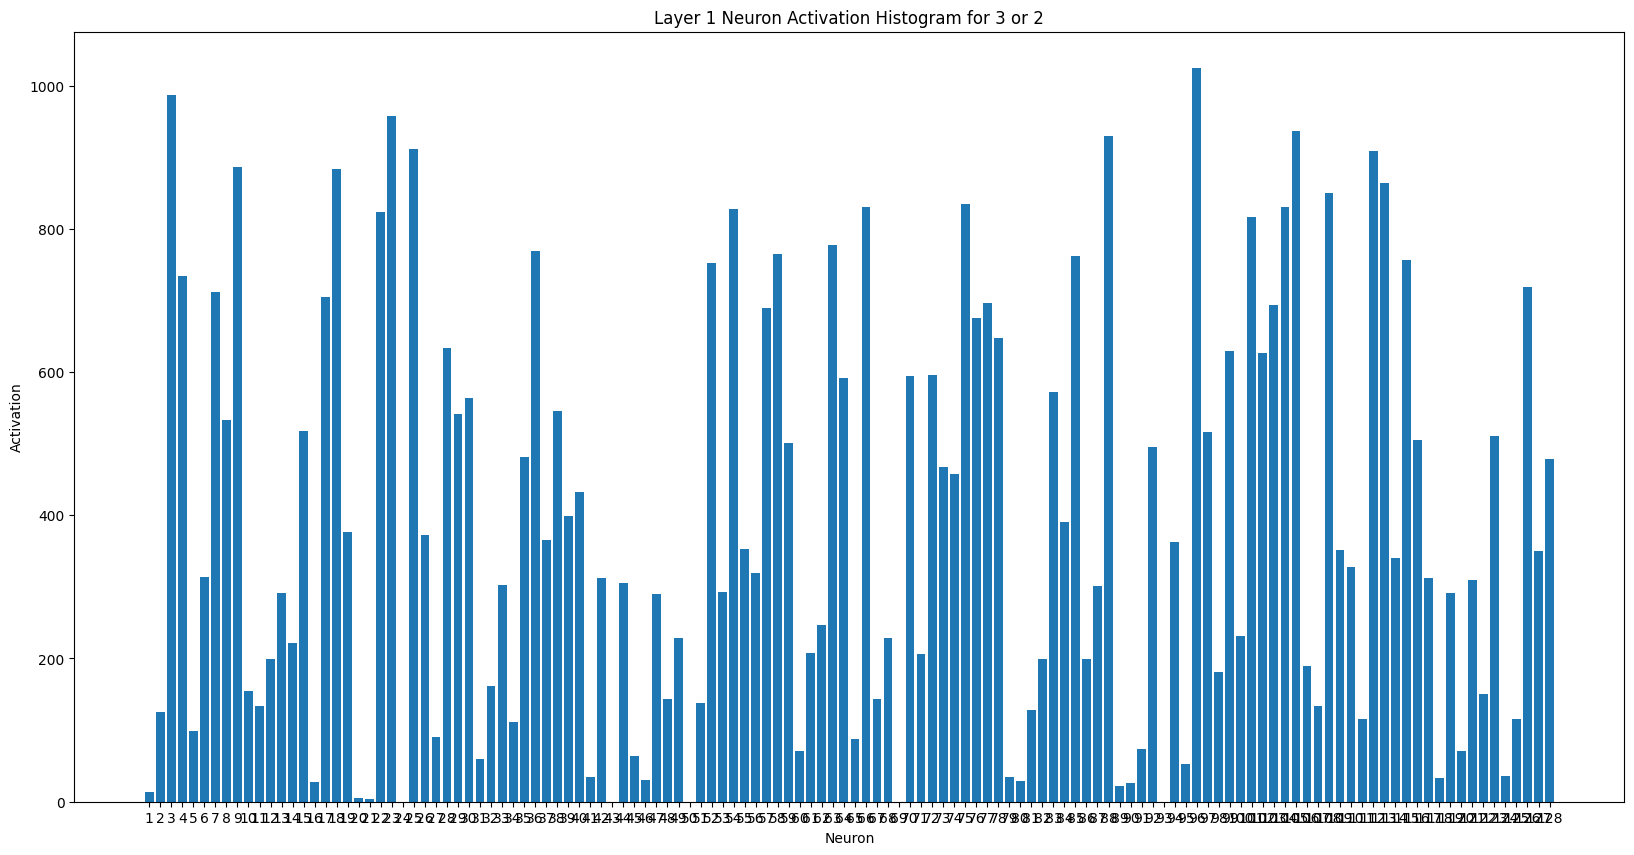

In [98]:
df_layer1_2_binary = df_layer1_binary[df_layer1['Number'] == 2]
df_layer1_3_binary = df_layer1_binary[df_layer1['Number'] == 3]

df_layer1_2_3_or = df_layer1_2_binary | df_layer1_3_binary
df_layer1_2_3_or = df_layer1_2_3_or.astype(int).drop(columns=['Number'])

# plot the activation histogram do a or of all rows and plot the result in a bar plot

# or of all rows
import re
df_layer1_2_3_or = df_layer1_2_3_or.sum(axis=0)

# plot the result in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df_layer1_2_3_or.index.map(lambda x: re.findall(r'\d+', x)[1]), df_layer1_2_3_or.values)
plt.title('Layer 1 Neuron Activation Histogram for 3 or 2')
plt.xlabel('Neuron')
plt.ylabel('Activation')
plt.show()

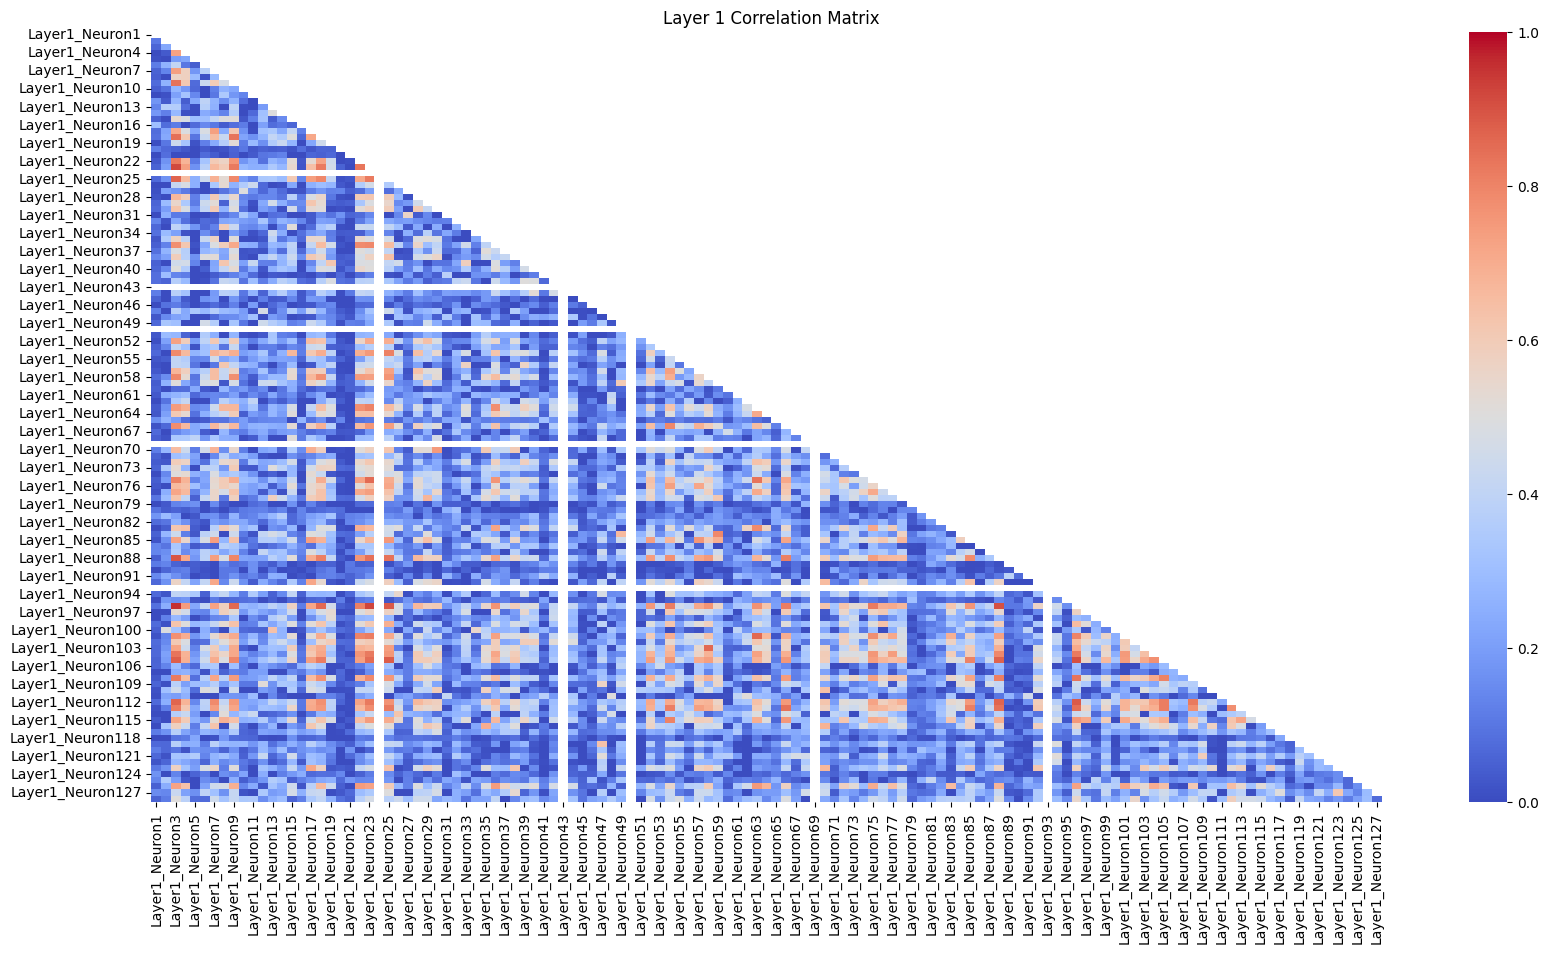

In [69]:
correlation_matrix(df_layer1_2_3_or, 'Layer 1 Correlation Matrix')

In [42]:
#plot tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne(data, title):
    tsne = TSNE(n_components=2, random_state=SEED)
    tsne_results = tsne.fit_transform(data.drop(columns=['Number']))

    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=data['Number'],
        palette=sns.color_palette("husl", 11),
        legend="full",
        alpha=0.3,
    )
    plt.title(title)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categor

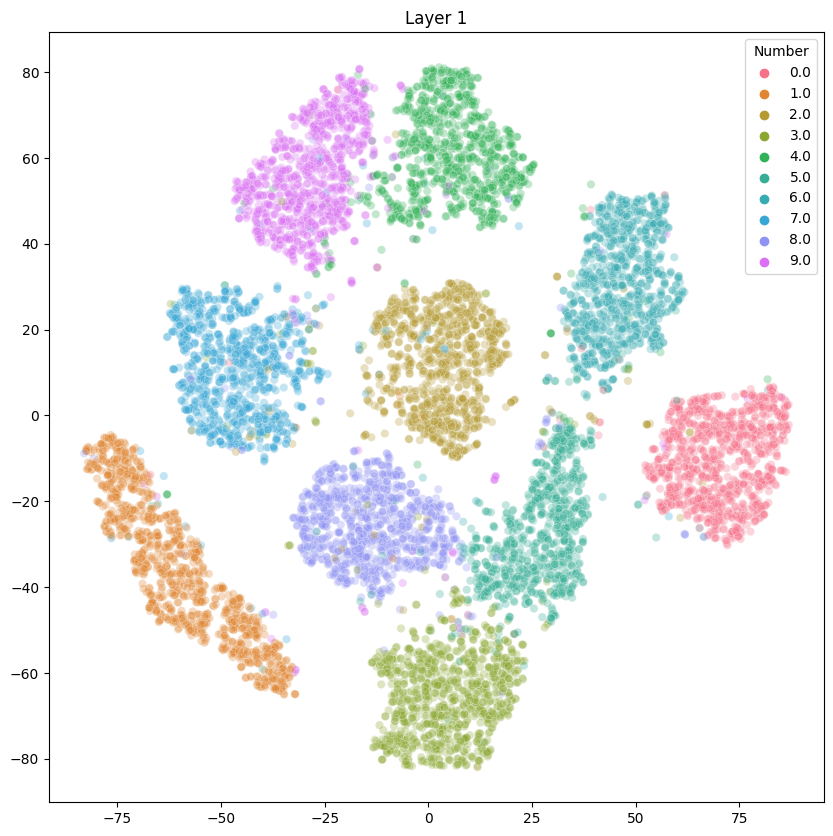

In [43]:
plot_tsne(df_layer1, 'Layer 1')

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categor

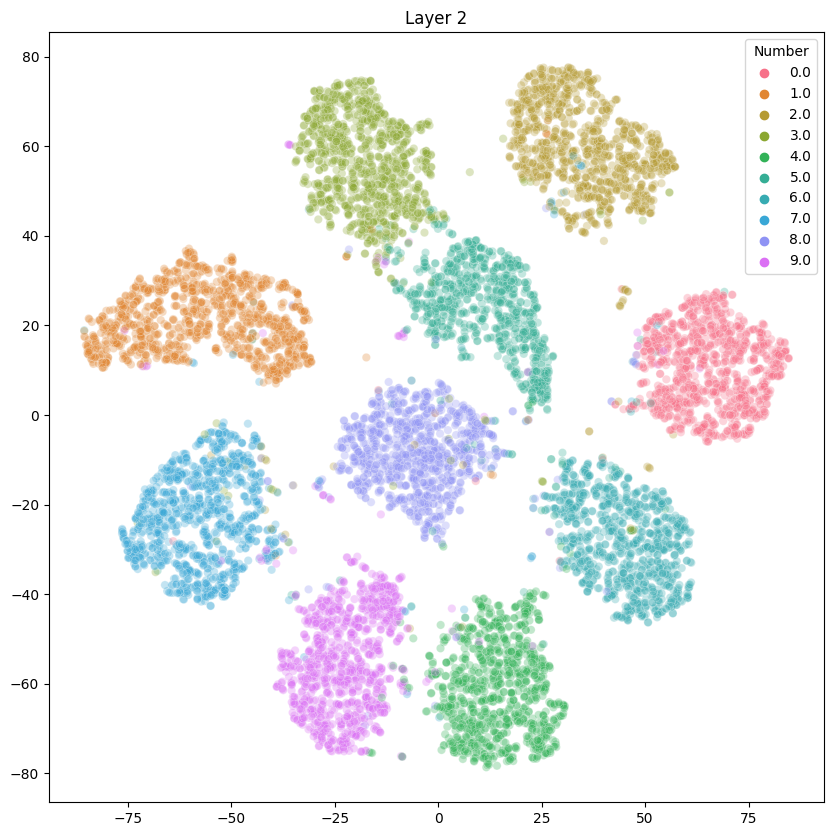

In [44]:
plot_tsne(df_layer2, 'Layer 2')

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categor

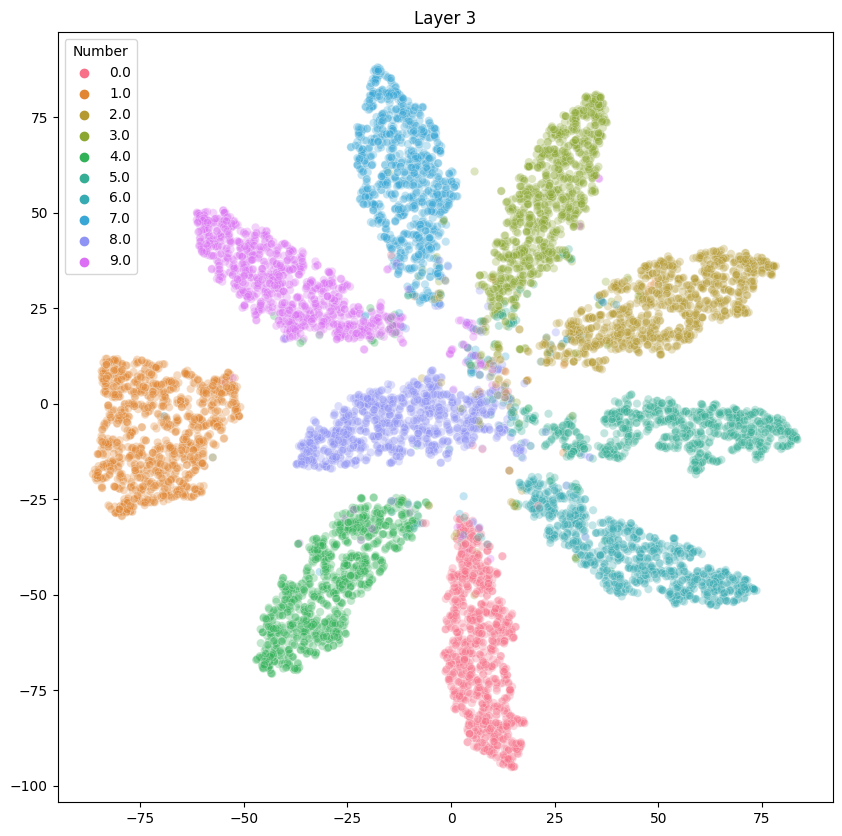

In [45]:
plot_tsne(df_layer3, 'Layer 3')